In [ ]:
#Import modules
%matplotlib inline

#handling data
import pandas as pd
import numpy as np
#from scipy import stats
from operator import itemgetter

#handling information
#import re
#import json

#handling plots
import matplotlib.pyplot as plt
#import seaborn as sns

#for network creation
import networkx as nx


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')#connecting the notebook to your drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
tweets=pd.read_csv('gdrive/My Drive/Colab Notebooks/tweets.csv')

In [ ]:
tweets.shape

(400, 33)

In [ ]:
tweets.head(1)

,tweet_id,tweet_created_at,source,original_text,tweet_favorite_count,retweet_count,hashtags,user_mentions,user_mentions_id,topic,keyword,emojis,possibly_sensitive,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,user_id,user_followers_count,user_listed_count,user_favourites_count,user_statuses_count,user_created_at,user_screen_name,place,latitude_corr,longitude_corr,place_coord_boundaries,retweet_tweet_id,retweet_user_id,retweet_user_screen_name,retweet_in_reply_to_screen_name,retweet_in_reply_to_status_id,retweet_in_reply_to_user_id
0,1295657280768225280,Tue Aug 18 09:42:22 +0000 2020,"<a href=""http://twitter.com/download/android"" ...","On @realDonaldTrump's watch, 173,716 Americans...",0,19,COVID19,"COVID_Scale, realDonaldTrump","[908781126495305728, 25073877]",Technology,wikipedia,{},NaN,NaN,NaN,NaN,855594953011068928,72,0,9022,2306,Sat Apr 22 01:31:47 +0000 2017,tracy_merrick,"Fishers, IN",39.955593,-86.013873,NaN,1.295655e+18,9.087811e+17,COVID_Scale,1.295655e+18,NaN,NaN


In [ ]:
tweets.columns

Index(['tweet_id', 'tweet_created_at', 'source', 'original_text',
       'tweet_favorite_count', 'retweet_count', 'hashtags', 'user_mentions',
       'user_mentions_id', 'topic', 'keyword', 'emojis', 'possibly_sensitive',
       'in_reply_to_status_id', 'in_reply_to_user_id',
       'in_reply_to_screen_name', 'user_id', 'user_followers_count',
       'user_listed_count', 'user_favourites_count', 'user_statuses_count',
       'user_created_at', 'user_screen_name', 'place', 'latitude_corr',
       'longitude_corr', 'place_coord_boundaries', 'retweet_tweet_id',
       'retweet_user_id', 'retweet_user_screen_name',
       'retweet_in_reply_to_screen_name', 'retweet_in_reply_to_status_id',
       'retweet_in_reply_to_user_id'],
      dtype='object')

https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb

In [ ]:
# 1. Export edges from Retweets
retweets=tweets.loc[tweets['retweet_tweet_id'] != None]
edges=retweets[['user_id','retweet_tweet_id','tweet_created_at']]
edges.columns = ['Source', 'Target', 'Strength']


In [ ]:
# 2. Export edges from Mentions

mentions = tweets[tweets['user_mentions'].notnull()]

edges = pd.DataFrame(columns=('Source','Target','Strength'))

for index, row in mentions.iterrows():
    mention_list = row['user_mentions'].split(", ")
    for mention in mention_list:
      edges = edges.append(pd.DataFrame([[row['user_id'],
                                        row['user_mentions_id'],
                                        row['tweet_created_at']]]
                                        , columns=('Source','Target','Strength')), ignore_index=True)


In [ ]:
# 3. Export edges from Replies

replies = tweets[tweets['in_reply_to_status_id'].notnull()]
add_edges=replies[['user_id', 'in_reply_to_status_id','tweet_created_at']]
add_edges.columns=['Source','Target','Strength']
edges = edges.append(add_edges, ignore_index=True)


In [ ]:
edges=edges.groupby(['Source', 'Target'])['Strength'].count().reset_index()

In [ ]:
edges

,Source,Target,Strength
0,763224,[3334677605],1
1,11697632,"[908781126495305728, 25073877]",2
2,14556182,"[908781126495305728, 25073877]",2
3,15574989,[128108354],1
4,16011840,"[291740968, 66773314, 4797803236]",3
...,...,...,...
377,1294905400924311552,[1213056865128480768],1
378,1295249045137440769,[1243491467542200320],1
379,1295249045137440769,[905790964576378880],2
380,1295277219095306240,"[1294848751224274945, 1291340874618556422]",2


In [ ]:
edges.shape

(382, 3)

Export nodes


In [ ]:
edges.isnull().sum()

Source      0
Target      0
Strength    0
dtype: int64

In [ ]:
users = tweets[['user_id','user_followers_count','user_screen_name']]
users = users.sort_values(['user_id','user_followers_count'], ascending=[True, False])
users = users.drop_duplicates(['user_id'], keep='first') 

In [ ]:
users

,user_id,user_followers_count,user_screen_name
101,763224,2496,jrobertson
21,11697632,468,Nowist
341,14556182,2783,Vuduchick
183,14813188,1632,techdudeinc
393,15574989,49,carolynbclark16
...,...,...,...
293,1294905400924311552,1,PawanKu47761259
93,1295067601710665729,0,Gopal18512284
113,1295249045137440769,40,NlognHQ
322,1295277219095306240,0,Abhijee28873343


In [ ]:
users.isnull().sum()

user_id                 0
user_followers_count    0
user_screen_name        0
dtype: int64

In [ ]:
# Export nodes from the edges and add node attributes for both Sources and Targets.

users = tweets[['user_id','user_followers_count','user_screen_name']]
users = users.sort_values(['user_id','user_followers_count'], ascending=[True, False])
users = users.drop_duplicates(['user_id'], keep='first') 

ids = edges['Source'].append(edges['Target']).to_frame()
ids['Label'] = ids
ids.columns = ['Label', 'user_id']
ids = ids.drop_duplicates(['Label'], keep='first') 
nodes = pd.merge(ids, users, on='user_id', how='left')

In [ ]:
print(nodes.shape)
print(edges.shape)

(584, 4)
(382, 3)


In [ ]:
# Print nodes to check
nodes.head(3)

,Label,user_id,user_followers_count,user_screen_name
0,763224,763224,2496.0,jrobertson
1,11697632,11697632,468.0,Nowist
2,14556182,14556182,2783.0,Vuduchick


In [ ]:
# Print edges to check
edges.head(3)

,Source,Target,Strength
0,763224,[3334677605],1
1,11697632,"[908781126495305728, 25073877]",2
2,14556182,"[908781126495305728, 25073877]",2


In [ ]:
graph = nx.from_pandas_edgelist(edges, source='Source', target='Target')


There are two other important functions to create a Graph. The first one is add_node()and the second one, add_edge both with a very descriptive name. Let's pay attention to the syntax of add_edge:

Graph.add_edge(u_of_edge, v_of_edge, **attr)

where u, v are the nodes, and attr are keyword arguments that characterize the edge data such as weight, capacity, length, etc.

If we add an edge that already exists, the edge data will get updated. Also, if we are an edge between two nodes that are still not in the Graph, the nodes will be created in the process. We are going to populate the Graph by calling the function get_interactions that we defined earlier. With this information, we apply the function add_edge to every tuple consisting of the tweet's user_id and the user_id of the user mentioned, replied to or retweeted, creating the nodes and the edges connecting them. Also, the tweet id will be added as edge data.

Now that we have the node and edge of the Graph created, let's see the number of nodes and edges present:



In [ ]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 584 nodes and 382 edges present in the Graph


The degree of a node u, denoted as deg(u), is the number of edges that occur to that node. In simpler words, the number of connections a particular node has. The maximum degree of a graph and the minimum degree of a graph are the maximum and minimum degree of its nodes, respectively.

In [ ]:
degrees = [val for (node, val) in graph.degree()]

In [ ]:
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 20
The minimum degree of the Graph is 1


An undirected graph is connected if, for every pair of nodes, there is a path between them. For that to happen, most of the nodes should have at least a degree of two, except for those denominated leaves which have a degree of 1. From the characteristics of the Graph, we can suspect that the graph is not connected. In order to confirm these, we can use nx.is_connected.

In [ ]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


Now, that we confirm that our Graph is not connected, we can check how many connected components it has:

In [ ]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 210 connected components in the Graph


In [ ]:
S = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]

In [ ]:
num_nodes=[]
num_edges=[]
for i in range(len(S)):
  num_nodes.append(S[i].number_of_nodes())
  num_edges.append(S[i].number_of_edges())


In [ ]:
for i in range(len(S)):
  print(f"There are {S[i].number_of_nodes()} nodes and {S[i].number_of_edges()} edges present in the Graph S",i)

In [ ]:
num_nodes.index(max(num_nodes))

54

In [ ]:
num_edges.index(max(num_edges))

54

In [ ]:
largest_subgraph=S[54]

In [ ]:
num_nodes.index(max(num_nodes))
num_nodes

[13, 3, 5, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [ ]:
max_index = num_edges.index(max(num_edges))
max_edges = max(num_edges)



In [ ]:
largest_subgraph=S[max_index]


In [ ]:
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

There are 33 nodes and 40 edges present in the largest component of the Graph


In [ ]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is connected



Clustering and transitivity measure the tendency for nodes to cluster together or for edges to form triangles. In our context, they are measures of the extent to which the users interacting with one particular user tend to interact with each other as well. The difference is that transitivity weights nodes with a large degree higher.  The clustering coefficient, a measure of the number of triangles in a graph, is calculated as the number of triangles connected to node i divided by the number of sets of two edges connected to node i (Triple nodes). While the transitivity coefficient is calculated as 3 multiply by the number of triangles in the network divided by the number of connected triples of nodes in the network. These two parameters are very important when analyzing social networks because it gives us an insight into how users tend to create tightly knot groups characterized by relatively high-dense ties.

In [ ]:
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0


After that, we'll investigate some summary statistics, particularly related to distance, or how far away one node is from another random node. Diameter represents the maximum distance between any pair of nodes while the average distance tells us the average distance between any two nodes in the network.

In [ ]:
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

The diameter of our Graph is 8
The average distance between any two nodes is 3.32



Now, we are going to focus on network centrality which captures the importance of a node's position in the network considering: degree on the assumption that an important node will have many connections, closeness on the assumption that important nodes are close to other nodes, and finally, betweenness on the assumption that important nodes are well situated and connect other nodes. For this, we are going to use the following functions degree_centrality, closenness_centrality and betwenness_centrality, all which return a list of each node and its centrality score. We will particularly capture the node with the best score in each one.

In [ ]:
graph_centrality = nx.degree_centrality(largest_subgraph)

In [ ]:
#graph_centrality

In [ ]:
max_de = max(graph_centrality.items(), key=itemgetter(1))

In [ ]:
#max_de

In [ ]:
graph_closeness = nx.closeness_centrality(largest_subgraph)

In [ ]:
max_clo = max(graph_closeness.items(), key=itemgetter(1))

In [ ]:
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)

In [ ]:
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [ ]:
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id [905790964576378880] has a degree centrality of 0.34 which is the maximum of the Graph
the node with id 1190726565073522694 has a closeness centrality of 0.48 which is the maximum of the Graph
the node with id [905790964576378880] has a betweenness centrality of 0.60 which is the maximum of the Graph


Now, we can get to see how the Graph looks like. For that, we will use nx.drawing.layout to apply node positioning algorithms for the graph drawing. Specifically, we will use spring_layout that uses force-directed graph drawing which purpose is to position the nodes in two-dimensional space so that all the edges are of equal length and as few crossing edges as possible. It achieves this by assigning forces among the set of edges and nodes based on their relative positions and then uses this to simulate the motion of the edges and nodes. One of the parameters that we can adjust is k, the optimal distance between nodes; as we increase the value, the nodes will farther apart. Once, that we got the positions, we are also going to create a special list so that we can draw the two nodes with higher centrality that we found in different colors to highlight them.

In [ ]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = [max_de[0], max_clo[0]]

In [ ]:
#pos = nx.spring_layout(largest_subgraph, k=0.05, weight='Strength')

In [ ]:
pos = nx.spring_layout(largest_subgraph)

After all that calculation, we'll use the functions .draw_networkx_nodes() and .draw(). And finally, we have the drawing of the largest connected component of our original Graph:

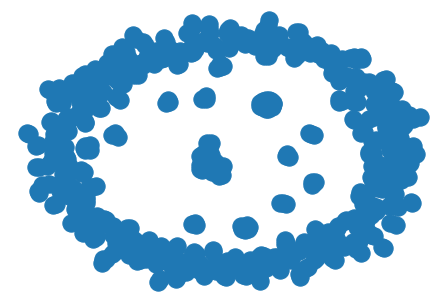

In [ ]:
nx.draw(graph,with_labels=False)
plt.draw()
plt.show()

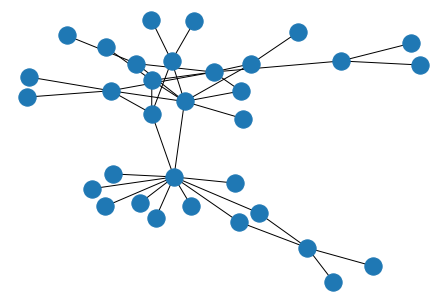

In [ ]:
nx.draw(largest_subgraph,with_labels=False)
plt.draw()
plt.show()

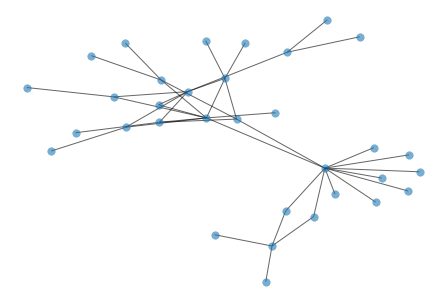

In [ ]:
nx.draw(largest_subgraph,pos=pos,cmap=plt.cm.PiYG,linewidths=0.3, node_size=60, alpha=0.6,with_labels=False)
plt.draw()
plt.show()

In [ ]:
pos2 = nx.spring_layout(largest_subgraph, k=0.05, weight='Strength')

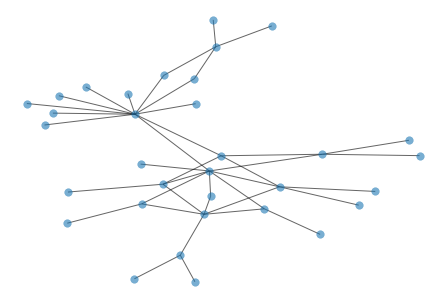

In [ ]:
nx.draw(largest_subgraph,pos=pos2,cmap=plt.cm.PiYG,linewidths=0.3, node_size=60, alpha=0.6,with_labels=False)
plt.draw()
plt.show()

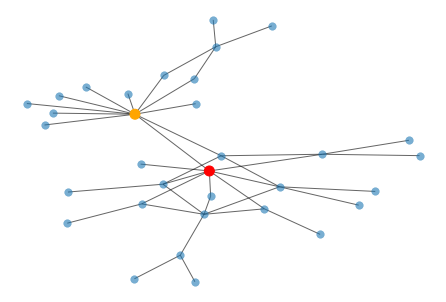

In [ ]:
nx.draw(largest_subgraph,pos=pos2,cmap=plt.cm.PiYG,linewidths=0.3, node_size=60, alpha=0.6,with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos2, nodelist=central_nodes, node_size=100, node_color=colors_central_nodes)
plt.draw()
plt.show()

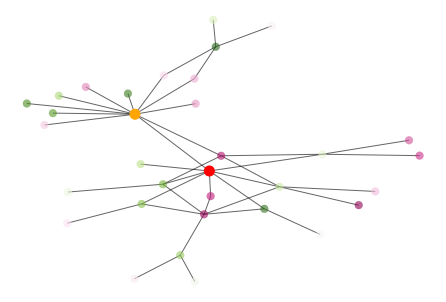

In [ ]:
nx.draw(largest_subgraph,pos=pos2,node_color=range(33), cmap=plt.cm.PiYG,linewidths=0.3, node_size=60, alpha=0.6,with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos2, nodelist=central_nodes, node_size=100, node_color=colors_central_nodes)
plt.draw()
plt.show()

https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

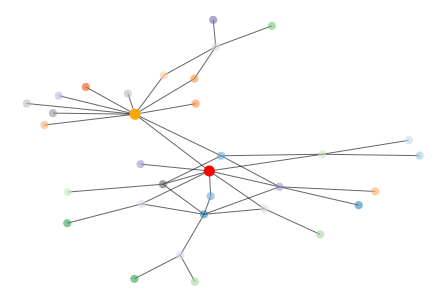

In [ ]:
nx.draw(largest_subgraph,pos=pos2,node_color=range(33), cmap=plt.cm.tab20c,linewidths=0.3, node_size=60, alpha=0.6,with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos2, nodelist=central_nodes, node_size=100, node_color=colors_central_nodes)
plt.draw()
plt.show()

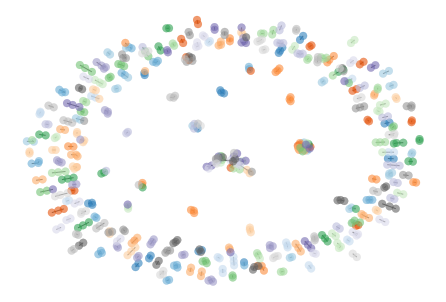

In [ ]:
nx.draw(graph,node_color=range(584) ,cmap=plt.cm.tab20c,edge_color="black",linewidths=0.3, node_size=60, alpha=0.6,with_labels=False)
plt.draw()
plt.show()